In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF

#### Data
Datasets used: Movies (ratings_matrix) and Book Crossing dataset (books_data_matrix)

In [2]:
LR = 10

In [3]:
def ratings_matrix():
    train = pd.read_csv("movies/ratings.csv")
    train = np.array(train.pivot(index = 'movieId', columns = 'userId', values = 'rating'))
    train = np.nan_to_num(train)
    return train
    

In [4]:
def books_data_matrix():
    dataset = BookCrossingReader(0.8,0.9)
    t = dataset.URM_train.todense().T
    return t

In [5]:
X = ratings_matrix()
# X = books_data_matrix()

In [7]:
h, w = X.shape
inner = 50

In [8]:
W = np.random.random((h, inner))
H = np.random.random((inner, w))

In [9]:
def cost(X, W, H):
    Xwh = np.dot(W, H)
    E = X - Xwh
    return np.sqrt(LR * np.mean(np.square(E)))

In [10]:
def update(X, W, H):
    N = np.dot(X, H.T)
    D = np.dot(W, H).dot(H.T)
    U = np.divide(N, D)
    where_are_NaNs = np.isnan(U)
    U[where_are_NaNs] = 0
    Wu = np.multiply(W, U)
    return Wu

In [11]:
def optimize(X, W, H):
    Wt = update(X, W, H)
    Ht = update(X.T, H.T, Wt.T)
    cost_value = cost(X, Wt, Ht.T)
    return Wt, Ht.T, cost_value

In [12]:
losses = []

In [14]:
for i in range(200):
    W, H, c = optimize(X, W, H)
    losses.append(c)
    if i % 2 == 0:
        print("Cost value: {}".format(c))

Cost value: 1.344310062700654
Cost value: 1.3270784926936885
Cost value: 1.3104314585231807
Cost value: 1.2729807219954037
Cost value: 1.223217017882504
Cost value: 1.1818556877199227
Cost value: 1.1498656764802926
Cost value: 1.1249140844382088
Cost value: 1.1056280184251526
Cost value: 1.090472323849949
Cost value: 1.078466267423692
Cost value: 1.069059014139495
Cost value: 1.0616984959250448
Cost value: 1.0558996077077922
Cost value: 1.051243011299812
Cost value: 1.047453715244722
Cost value: 1.0443146412762643
Cost value: 1.0416822559589252
Cost value: 1.0394249738945271
Cost value: 1.0374552590251003
Cost value: 1.0357138258793848
Cost value: 1.0341750070027242
Cost value: 1.032810199486384
Cost value: 1.0314414926282718
Cost value: 1.0302630682036502
Cost value: 1.0292042779555355
Cost value: 1.028228323019229
Cost value: 1.027316251429214
Cost value: 1.0264549602815085
Cost value: 1.0256410028984289
Cost value: 1.0248880978914132
Cost value: 1.0242124019919296
Cost value: 1.0235

In [15]:
cost(X, W, H)

1.0129874617660903

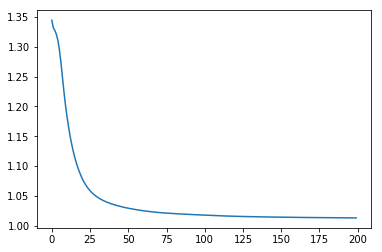

In [16]:
plt.plot(losses)

In [3]:
import numpy as np
import scipy.sparse as sps
import os
import random
import sys
import pandas as pd


class BookCrossingReader(object):
    #TODO: aggiungere validation option.
    def __init__(self, train_test_split=None, train_validation_split=None, delete_popular=None, top_popular_threshold=0.33):
        '''
        :param train_test_split: is the percentage of the training set
        '''


        dir = 'BX-CSV-Dump/'
        filename = dir+"/BX-Book-Ratings.csv"
        from numpy import genfromtxt
        fileHandle = pd.read_csv(filename, sep=";", encoding="ISO-8859-1")
        #fileHandle = open(filename, "r")

        rows, cols, vals = [], [], []
        numCells = 0
        fileHandle['ISBN'], levels = pd.factorize(fileHandle['ISBN'])
        fileHandle['User-ID'], levels = pd.factorize(fileHandle['User-ID'])
        print(fileHandle.iloc[0:100])

        #fileHandle['User'], levels = pd.factorize(fileHandle['ISBN'] )

        #print(fileHandle)

        #These arrays are sorted by user
        self.users = np.array(fileHandle['User-ID']).astype(int)
        self.movies = np.array(fileHandle['ISBN']).astype(int)
        self.ratings = np.array(fileHandle['Book-Rating']).astype(float)

        if delete_popular:
            unique, counts = np.unique(self.movies, return_counts=True)
            dictionary = dict(zip(unique, counts))
            sorted_dictionary = sorted(dictionary.items(), key=lambda x: x[1])
            cutting_index = round(len(sorted_dictionary)*(1-top_popular_threshold))
            least_popular_item = [x[0] for x in sorted_dictionary[:cutting_index]]

            popular_mask = []
            for item in self.movies:

                if item in least_popular_item:
                    popular_mask.append(True)
                else:
                    popular_mask.append(False)

            self.movies = self.movies[popular_mask]
            self.users = self.users[popular_mask]
            self.ratings = self.ratings[popular_mask]

        self.unique_movies = np.sort(np.unique(self.movies)).astype(int)
        self.unique_users = np.sort(np.unique(self.users))
        '''
        #These arrays are sorted by item
        self.users_by_item = np.array(data2[:,0])
        self.items_by_item = np.array(data2[:,1])
        self.ratings_by_item = np.array(data2[:,2])
   
        # gli id degli users partono da 1 e sono tutti consecutivi, quindi l'unica
        # riga della URM che ha tutti 0 è la prima (riga 0) che quindi eliminiamo
        '''
        URM_all_partial = sps.csr_matrix((self.ratings, (self.users, self.movies)), dtype=np.float32)
        self.URM_all = URM_all_partial
        self.URM_all = self.URM_all.tocoo()

        num_interactions = self.URM_all.nnz

        train_mask = np.random.choice([True, False], num_interactions, p=[train_test_split, 1 - train_test_split])
        test_mask = np.logical_not(train_mask)

        if train_validation_split is not None:

            splitted_test_mask = [random.choice([True, False]) if x else False for x in test_mask]
            validation_mask = np.logical_and(np.logical_not(splitted_test_mask), test_mask)

            self.URM_validation = sps.csr_matrix((self.ratings[validation_mask], (self.users[validation_mask], self.movies[validation_mask])))

        elif train_test_split is not None:
            train_mask = np.random.choice([True, False], num_interactions, p=[train_test_split, 1 - train_test_split])

            test_mask = np.logical_not(train_mask)

        else:
            raise Exception("One between train_test_split and train_validation_split must be valid")

        #mask = np.random.choice([True, False], len(self.unique_users), p=[0.3, 0.7])

        self.URM_test = sps.csr_matrix((self.ratings[test_mask], (self.users[test_mask], self.movies[test_mask])))
        print(self.URM_test.nnz)
        print(self.URM_test.shape[0])
        self.URM_test = self.URM_test[0:1000, :]
        print(self.URM_test.nnz)

        self.URM_train = sps.csr_matrix((self.ratings[train_mask], (self.users[train_mask], self.movies[train_mask])))
        self.URM_train = self.URM_train[0:1000, :]